In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [9]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [12]:
# setup sql stuff
Base = automap_base()
Base.prepare(engine,reflect = True)
Base.classes.keys()
Measurement = Base.classes.measurement
Station = Base.classes.station
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# Previous Years vacation days average
print(calc_temps("2017-08-01","2017-08-07"))

(72.0, 79.25, 83.0)


In [ ]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set

(0, 100)

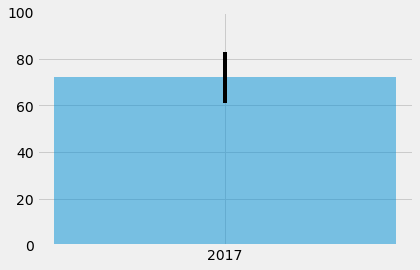

In [35]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
year_temp = calc_temps("2017-08-01","2017-08-07")
plt.bar(['2017'],year_temp[0][0],yerr = year_temp[0][2]-year_temp[0][0],alpha = .5)
plt.ylim(0,100)

### Daily Rainfall Average

In [86]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
#rps = session.query(Measurement.station,func.sum(Measurement.prcp)).group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc())
join = session.query(Measurement, Station).filter(Measurement.station == Station.station).group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()
sel = [func.sum(Measurement.prcp),Station.name,Station.longitude, Station.latitude,Station.elevation]
join = session.query(*sel).filter(Measurement.station == Station.station).group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()
for x in join:
    print(x)
#min = session.query(func.min(mt.tobs).filter(mt.date >= start).filter(mt.date <= end))[0][0]

(1068.0899999999956, 'MANOA LYON ARBO 785.2, HI US', -157.8025, 21.3331, 152.4)
(588.6399999999976, 'WAIHEE 837.5, HI US', -157.84888999999998, 21.45167, 32.9)
(382.61999999999847, 'KANEOHE 838.1, HI US', -157.8015, 21.4234, 14.6)
(295.67999999999944, 'WAIMANALO EXPERIMENTAL FARM, HI US', -157.71139, 21.33556, 19.5)
(234.49000000000026, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', -157.8374, 21.5213, 7.0)
(131.62000000000063, 'WAIKIKI 717.2, HI US', -157.8168, 21.2716, 3.0)
(92.68000000000006, 'HONOLULU OBSERVATORY 702.2, HI US', -157.9992, 21.3152, 0.9)
(70.87000000000005, 'UPPER WAHIAWA 874.3, HI US', -158.0111, 21.4992, 306.6)
(43.44000000000002, 'PEARL CITY, HI US', -157.9751, 21.3934, 11.9)


### Daily Temperature Normals

In [ ]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates


# Strip off the year and save a list of strings in the format %m-%d


# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

In [ ]:
# Plot the daily normals as an area plot with `stacked=False`

## Close Session